## 01. 데이터 소개 및 분석 프로세스 수립

## 02. 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from catboost import Pool, CatBoostClassifier

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

#### 1) 대출 승인내역 불러오기

- issue_d 컬럼은 parse_dates 사용
- infer_datetime_format = True
- reset_index(drop=True) 사용

In [2]:
data = pd.read_csv('accepted_2007_to_2018Q4.csv', parse_dates=['issue_d'], infer_datetime_format=True)
data = data[(data.issue_d >= '2018-01-01 00:00:00') & (data.issue_d < '2019-01-01 00:00:00')]
data = data.reset_index(drop=True) # index를 새로 설정함.
data.head()

C:\Users\jjoro\AppData\Local\Temp/ipykernel_11392/1651784295.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('accepted_2007_to_2018Q4.csv', parse_dates=['issue_d'], infer_datetime_format=True)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,130954621,NaN,5000.0,5000.0,5000.0,36 months,20.39,186.82,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,130964697,NaN,15000.0,15000.0,15000.0,36 months,9.92,483.45,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,130955326,NaN,11200.0,11200.0,11200.0,60 months,30.79,367.82,G,G1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,130504052,NaN,25000.0,25000.0,25000.0,60 months,21.85,688.35,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


#### 2) 대출용어 사전 불러오기
- pandas의 read_excel 사용/Excel Sheet 중 2번째 (sheet_name=1)을 불러온다.

In [3]:
browse_notes = pd.read_excel('LCDataDictionary.xlsx', sheet_name=1, engine='openpyxl')
browse_notes.head()

,BrowseNotesFile,Description
0,acceptD,The date which the borrower accepted the offer
1,accNowDelinq,The number of accounts on which the borrower i...
2,accOpenPast24Mths,Number of trades opened in past 24 months.
3,addrState,The state provided by the borrower in the loan...
4,all_util,Balance to credit limit on all trades


In [4]:
browse_notes = browse_notes[['BrowseNotesFile', 'Description']]

In [5]:
browse_notes.head()

,BrowseNotesFile,Description
0,acceptD,The date which the borrower accepted the offer
1,accNowDelinq,The number of accounts on which the borrower i...
2,accOpenPast24Mths,Number of trades opened in past 24 months.
3,addrState,The state provided by the borrower in the loan...
4,all_util,Balance to credit limit on all trades


### 1. 데이터 전처리

- 기준정보 데이터와 대출승인 데이터의 정합성 맞추기

#### 1) 대출용어 사전 결측값 제거

In [6]:
browse_notes['BrowseNotesFile'].dropna().values # 결측값을 제거함.

array(['acceptD', 'accNowDelinq', 'accOpenPast24Mths', 'addrState',
       'all_util', 'annual_inc_joint', 'annualInc', 'application_type',
       'avg_cur_bal', 'bcOpenToBuy', 'bcUtil', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'creditPullD', 'delinq2Yrs',
       'delinqAmnt', 'desc', 'dti', 'dti_joint', 'earliestCrLine',
       'effective_int_rate', 'emp_title', 'empLength', 'expD',
       'expDefaultRate', 'ficoRangeHigh', 'ficoRangeLow', 'fundedAmnt',
       'grade', 'homeOwnership', 'id', 'il_util', 'ils_exp_d',
       'initialListStatus', 'inq_fi', 'inq_last_12m', 'inqLast6Mths',
       'installment', 'intRate', 'isIncV', 'listD', 'loanAmnt',
       'max_bal_bc', 'memberId', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mortAcc', 'msa',
       'mths_since_last_major_derog', 'mths_since_oldest_il_open',
       'mths_since_rcnt_il', 'mthsSinceLastDelinq', 'mthsSinceLastRecord',
       'mthsSinceMostRecentInq', 'mthsSinceRecentBc',

In [7]:
browse_feat = browse_notes['BrowseNotesFile'].dropna().values

#### 2) 대출용어 사전과 대출승인 데이터 문자열 규칙 맞추기 (정규식)

- 대문자, 숫자 앞에 '_' 붙여주고 모두 소문자 변환.
    > re.sub('(?<![0-9_])(?=[A-Z0-9])','_',x).lower()
    
- 공백 처리.
    > .strip()

In [8]:
browse_feat = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in browse_feat]

In [9]:
browse_feat

['accept_d',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc_joint',
 'annual_inc',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'credit_pull_d',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'effective_int_rate',
 'emp_title',
 'emp_length',
 'exp_d',
 'exp_default_rate',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'grade',
 'home_ownership',
 'id',
 'il_util',
 'ils_exp_d',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'is_inc_v',
 'list_d',
 'loan_amnt',
 'max_bal_bc',
 'member_id',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'msa',
 'mths_since_last_major_derog',
 'mths_since_oldest_il_open',
 'mths_since_rcnt_il',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_most_recent_inq',
 'mths_since_recent_b

#### 3) 대출승인 데이터 컬럼과 대출용어 간의 차이를 확인한다

- np.setdiff1d(ar1, ar2): ar2에는 없는 ar1의 고유한 값을 반환.

In [10]:
data_feat = data.columns.values
np.setdiff1d(browse_feat, data_feat)

# data_feat에는 없는 browse_feat의 고유한 값.

array(['accept_d', 'credit_pull_d', 'effective_int_rate', 'exp_d',
       'exp_default_rate', 'ils_exp_d', 'is_inc_v', 'list_d', 'msa',
       'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
       'mths_since_recent_loan_delinq', 'open_il_6m', 'review_status',
       'review_status_d', 'service_fee_rate', 'verified_status_joint'],
      dtype='<U30')

In [11]:
np.setdiff1d(data_feat, browse_feat)

array(['collection_recovery_fee', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'deferral_term',
       'disbursement_method', 'funded_amnt_inv', 'hardship_amount',
       'hardship_dpd', 'hardship_end_date', 'hardship_flag',
       'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'issue_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
       'last_pymnt_d', 'loan_status', 'mo_sin_old_il_acct',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'next_pymnt_d', 'open_act_il',
       'orig_projected_additional_accrued_interest', 'out_prncp',
       'out_prncp_inv', 'payment_plan_start_date', 'policy_code',
       'pymnt_plan', 'recoveries', 'revol_bal_joint',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'sec_ap

#### 4) 대출 시점(대출용어 사전)에서의 용어 중 대출승인 데이터 컬럼과 같은 의미인 용어를 서로 같게 만든다
  * 대출 시점(대출용어 사전)에서의 용어 중 대출승인 데이터 컬럼과 의미가 같지만 이름이 다른 컬럼들
          ['is_inc_v', 'mths_since_most_recent_inq','mths_since_oldest_il_open','mths_since_recent_loan_delinq', 'verified_status_joint']
  * 대출승인 데이터 컬럼에서의 이름들 (예: verified_status_join → verification_status_joint)
          ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct','mths_since_recent_bc_dlq', 'verification_status_joint']
  * np.setdiff1d / np.append 사용

In [12]:
wrong = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
         'mths_since_recent_loan_delinq', 'verified_status_joint']
correct = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

browse_feat = np.setdiff1d(browse_feat, wrong)
browse_feat = np.append(browse_feat, correct)

#### 5) 대출용어 사전과 대출승인 데이터 컬럼 이름이 같은 것들만 가져온다.

- np.intersect1d(ar1, ar2): ar1과 ar2의 공통된 항목들만 반환한다.

In [13]:
avail_feat = np.intersect1d(browse_feat, data_feat)
X = data[avail_feat].copy()

In [14]:
X.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,0.0,3.0,OK,58.0,50000.0,NaN,Individual,3869.0,384.0,23.2,...,19344.0,14118.0,500.0,0.0,27820.0,500.0,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,740xx
1,0.0,15.0,FL,51.0,196000.0,NaN,Individual,31468.0,7368.0,74.1,...,137713.0,113470.0,28500.0,1.0,147178.0,52400.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,337xx
2,0.0,5.0,NH,84.0,44000.0,81000.0,Joint App,8397.0,632.0,66.7,...,67173.0,65647.0,1900.0,1.0,74167.0,6200.0,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx
3,0.0,2.0,AL,90.0,65000.0,NaN,Individual,10685.0,63.0,98.1,...,17039.0,8382.0,3300.0,3.0,10220.0,8800.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,361xx
4,0.0,3.0,WA,1.0,52000.0,NaN,Individual,25099.0,30359.0,0.5,...,141.0,0.0,30500.0,2.0,0.0,31000.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,988xx


In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495242 entries, 0 to 495241
Data columns (total 94 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   acc_now_delinq                  495242 non-null  float64
 1   acc_open_past_24mths            495242 non-null  float64
 2   addr_state                      495242 non-null  object 
 3   all_util                        495113 non-null  float64
 4   annual_inc                      495242 non-null  float64
 5   annual_inc_joint                68985 non-null   float64
 6   application_type                495242 non-null  object 
 7   avg_cur_bal                     495202 non-null  float64
 8   bc_open_to_buy                  488654 non-null  float64
 9   bc_util                         488439 non-null  float64
 10  chargeoff_within_12_mths        495242 non-null  float64
 11  collections_12_mths_ex_med      495242 non-null  float64
 12  delinq_2yrs     

### 2. 데이터 타입별 Feature 변환

- 결측값 처리
- 기준정보 데이터와 대출승인 데이터의 정합성 맞추기

#### 1) 범주형 데이터 확인
- pandas 의 select_dtypes('object') 사용

In [16]:
X.select_dtypes('object').head()

,addr_state,application_type,desc,earliest_cr_line,emp_length,emp_title,grade,home_ownership,id,initial_list_status,purpose,sub_grade,term,title,url,verification_status,verification_status_joint,zip_code
0,OK,Individual,NaN,Jan-2009,8 years,General Manager,D,RENT,130954621,w,other,D4,36 months,Other,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,740xx
1,FL,Individual,NaN,Jul-1998,2 years,IT Director,B,OWN,130964697,w,debt_consolidation,B2,36 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,337xx
2,NH,Joint App,NaN,Jul-2007,< 1 year,Client services,G,RENT,130955326,w,medical,G1,60 months,Medical expenses,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,Not Verified,030xx
3,AL,Individual,NaN,Mar-1995,10+ years,Asphalt Supervisor,D,MORTGAGE,130504052,w,debt_consolidation,D5,60 months,Debt consolidation,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,361xx
4,WA,Individual,NaN,Jan-1998,9 years,Scale Technician,A,RENT,130956066,w,major_purchase,A4,36 months,Major purchase,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,988xx


#### 2) 범주형 문자열 데이터 중 날짜/기간/고유ID 데이터 처리
- pandas의 to_datetime 사용
- .str.extract('(\d+)').astype('float') 사용

In [17]:
# datetime type으로 변환.
X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
# X['sec_app_earliest_cr_line'] = pd.to_datetime(X['sec_app_earliest_cr_line'], infer_datetime_format=True)

In [18]:
X['emp_length'].unique() # str을 숫자형으로 바꿔주어야 의미가 있음.

array(['8 years', '2 years', '< 1 year', '10+ years', '9 years', nan,
       '5 years', '4 years', '1 year', '7 years', '3 years', '6 years'],
      dtype=object)

In [19]:
X['id']

0         130954621
1         130964697
2         130955326
3         130504052
4         130956066
            ...    
495237    130135401
495238    129961614
495239    130056422
495240    130065381
495241    129555354
Name: id, Length: 495242, dtype: object

In [20]:
# 부등호를 없앰.
X['emp_length'] = X['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
# years를 없앰.
X['emp_length'] = X['emp_length'].str.extract('(\d+)').astype('float')
X['id'] = X['id'].astype('float')

### 3. 결측값 처리
- 결측값 처리
- 기준정보 데이터와 대출승인 데이터의 정합성 맞추기

#### 1) 컬럼별 결측값 비율 구한 후, 비율=1 인 컬럼 제거
- .isna().mean()
- 컬럼별 결측값 비율이 0인 항목을 제외한 나머지 항목들을 pandas의 sort_values() 사용하여 정렬.
- 비율 = 1인 항목을 확인하여 pandas 의 drop으로 제거

In [21]:
X.isna() # True False로 되어있음.

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495237,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
495238,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
495239,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
495240,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [22]:
X.isna().mean()

acc_now_delinq               0.000000
acc_open_past_24mths         0.000000
addr_state                   0.000000
all_util                     0.000260
annual_inc                   0.000000
                               ...   
total_rev_hi_lim             0.000000
url                          0.000000
verification_status          0.000000
verification_status_joint    0.870748
zip_code                     0.000000
Length: 94, dtype: float64

In [23]:
nan_mean = X.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

pct_tl_nvr_dlq                    0.000004
avg_cur_bal                       0.000081
all_util                          0.000260
revol_util                        0.001195
dti                               0.002286
mths_since_recent_bc              0.012515
bc_open_to_buy                    0.013303
percent_bc_gt_75                  0.013319
bc_util                           0.013737
num_tl_120dpd_2m                  0.025046
mths_since_rcnt_il                0.037174
mo_sin_old_il_acct                0.037174
emp_length                        0.084781
emp_title                         0.110368
mths_since_recent_inq             0.123788
il_util                           0.163201
mths_since_last_delinq            0.558620
mths_since_recent_revol_delinq    0.711878
mths_since_last_major_derog       0.768128
mths_since_recent_bc_dlq          0.801895
dti_joint                         0.860704
annual_inc_joint                  0.860704
verification_status_joint         0.870748
mths_since_

1.00이면 전부 다 결측치라는 것. 제거해야 함.

In [24]:
X = X.drop(['desc', 'member_id'], axis=1, errors='ignore')

#### 2) 결측값 채우기
- 범주형 데이터의 결측값은 공백('')으로 채운다.
- 숫자형 데이터의 결측값은 대출 데이터 특성에 따라 데이터의 최대값, 최소값으로 각각 채운다.
- 최대값으로 채우는 경우 (값이 커졌을 때 대출 위험도가 줄어든다)
            'bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq'
- 최대값 이외에는 최소값으로 채운다.

분석 목표는 대출 위험도를 줄이는 것.

- 대출 위험도를 줄이는데 영향이 크다면 최소로.
- 대출 위험도를 줄이는데 영향이 작다면 최대로.

In [25]:
fill_empty = ['emp_title', 'verification_status_joint']

# 데이터 설명 시트의 빨간 항목 참조
# 최대값으로 해서 해당 항목으로 인해 부실 대출 방향으로 판단하지 않도록 함
fill_max = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq']

fill_min = np.setdiff1d(X.columns.values, np.append(fill_empty, fill_max))

X[fill_empty] = X[fill_empty].fillna('')
X[fill_max] = X[fill_max].fillna(X[fill_max].max())
X[fill_min] = X[fill_min].fillna(X[fill_min].min())

### 4. 변수 간 상관성에 따른 데이터 정제

#### 1) 숫자형 컬럼 데이터의 유일한 값 개수 확인
- pandas의 select_dtypes('number') 사용
- pandas의 nunique().sort_values() 사용
- 유일한 값이 1개인 경우/모든 행의 값이 다른 경우 둘 다 제거한다

In [26]:
num_feat = X.select_dtypes('number').columns.values
X[num_feat].nunique().sort_values()

num_tl_120dpd_2m                   1
acc_now_delinq                     2
num_tl_30dpd                       2
inq_last_6mths                     6
pub_rec_bankruptcies               8
                               ...  
total_il_high_credit_limit    128691
total_bal_ex_mort             139900
tot_cur_bal                   254794
tot_hi_cred_lim               266282
id                            495242
Length: 77, dtype: int64

In [27]:
X = X.drop(['num_tl_120dpd_2m', 'id'], axis=1, errors='ignore')

#### 2) 숫자형 데이터 상관도에 따른 컬럼 제거
- 숫자형 컬럼들 간 Pearson R 상관 계수를 구한다.
- 상관 계수가 0.9 이상인 컬럼들 중 가장 큰 컬럼을 제거해 본다.
- 컬럼들 간 조합 생성: comb_num_feat = np.array(list(combinations(num_feat, 2)))
- Pearson R 상관 계수 구하기: pearson(x1, x2)[0]

comb_num_feat = np.array(list(combinations(num_feat, 2)))

- np.array로 만들어달라.
- num_feat을 2개씩 combinations한 list를.
    - num_feat: number형 dtypes의 모든 columns들의 values들의 집합.

In [28]:
num_feat = X.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(X[comb[0]], X[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

corr_num_feat 중 절댓값이 0.9 이상인 것을 filtering

- 상관계수는 절댓값.

In [29]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['acc_now_delinq', 'num_tl_30dpd'],
       ['fico_range_high', 'fico_range_low'],
       ['funded_amnt', 'installment'],
       ['funded_amnt', 'loan_amnt'],
       ['installment', 'loan_amnt'],
       ['mo_sin_old_il_acct', 'mths_since_rcnt_il'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0'],
       ['num_sats', 'open_acc'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['total_bal_ex_mort', 'total_bal_il'],
       ['total_bal_il', 'total_il_high_credit_limit']], dtype='<U30')

이 중 가장 큰 값은 삭제하기.

In [30]:
X = X.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

#### 3) 범주형 데이터의 유일한 값 개수 확인
- pandas의 select_dtypes('object') 사용.
- pandas의 nunique().sort_values() 사용.
- 유일한 값이 1개인 경우/모든 행의 값이 다른 경우 둘 다 제거한다.
- 범주형 데이터의 경우 Encoding시 메모리 오류를 방지하기 위해 유일한 값이 많은 경우는 제거하는 것ㅇ ㅣ좋다.

In [31]:
cat_feat = X.select_dtypes('object').columns.values
X[cat_feat].nunique().sort_values()

application_type                  2
initial_list_status               2
term                              2
verification_status               3
home_ownership                    4
verification_status_joint         4
grade                             7
title                            12
purpose                          13
sub_grade                        35
addr_state                       50
zip_code                        897
emp_title                    129450
url                          495242
dtype: int64

- url은 각 행에 독립적으로 존재.
- emp_title 129450개는 메모리 오류를 야기.

In [32]:
X = X.drop(['url', 'emp_title'], axis=1, errors='ignore')

#### 4) 범주형 데이터 상관도에 따른 컬럼 제거
- 범주형 컬럼들 간 카이제곱 통계량을 사용하는 Crammer의 V 상관 계수를 구한다.
- Crammer의 V 상관계수 식 구하는 방법

```
  table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
  corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
```

- 상관 계수가 0.9 이상인 컬럼들 중 머신러닝 모델 생성 시 예측 변수의 조건으로 활용한 grade를 제외한 후 가장 높은 컬럼을 제거한다.
- 컬럼들 간 조합 생성: comb_cat_feat = np.array(list(combinations(cat_feat, 2)))

In [33]:
cat_feat = X.select_dtypes('object').columns.values
comb_cat_feat = np.array(list(combinations(cat_feat, 2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
    table = pd.pivot_table(X, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * np.min(table.shape) - 1))
    corr_cat_feat = np.append(corr_cat_feat, corr)

In [34]:
high_corr_cat = comb_cat_feat[corr_cat_feat >= 0.9]
high_corr_cat

array([['addr_state', 'zip_code'],
       ['grade', 'sub_grade'],
       ['purpose', 'title']], dtype='<U25')

여기서 grade는 target임.
- 가장 상관성이 높은 변수이기도 함.
- target이 아니었으면 이를 제거하는게 맞으나, target이기 때문에 유지하여야 함.
- 아래 코드에서 [:, 1]로 한 이유.

In [35]:
X = X.drop(np.unique(high_corr_cat[:, 1]), axis=1, errors='ignore')

### 5. 예측 변수 Feature 생성

대출 상태를 보여주는 'loan_stats'를 예측 변수 Feature로 한다

- load_status의 항목별 개수를 확인한다.
- 건전한 상태를 나타내는 'Current, Fully Paid, In Grace Peroid'를 1로 나타낸다.
- 그 외는 부실한 상태를 나타내는 0으로 나타낸다.

In [36]:
data['loan_status'].value_counts()

Current               427181
Fully Paid             47444
Charged Off             8867
Late (31-120 days)      7221
In Grace Period         2919
Late (16-30 days)       1603
Default                    7
Name: loan_status, dtype: int64

In [37]:
y = data['loan_status'].copy()
y = y.isin(['Current', 'Fully Paid', 'In Grace Period']).astype('int')
y.value_counts()

1    477544
0     17698
Name: loan_status, dtype: int64

## 03. 모델링

#### 1) 분석 목표는 '고위험/고금리 대출 중 양호한 대출을 예측하는 것'

- 위험도를 나타내는 grade 컬럼에서 가장 위험한 상태인 'E'에 해당하는 데이터만 가져온다.
- 위험도에 따라 설정되는 int_rate 컬럼은 제거한다.

In [38]:
X_mod = X[X.grade == 'E'].copy()
X_mod = X_mod.drop(['grade', 'int_rate'], axis=1, errors='ignore')
y_mod = y[X_mod.index]

X_mod 에서 X_train과 X_test를 확보하고 X_train을 다시 train과 val로 나눔.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, stratify=y_mod, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)

#### 2) 머신러닝 기법은 'CatBoost'를 사용한다.

- CatBoost는 범주가 많은 범주형 Feature를 포함하는 데이터셋에 매우 효율적.
- CatBoost는 범주형 데이터를 숫자형으로 변환하게 되고, 기본 설정으로 Mean Encoding 사용.
    - 단순하게 평균을 사용하게 되면 Data Leakage 문제가 발생.
        - 우리가 예측해야 하는 값이 훈련 데이터의 Feature에 들어가는 문제.
    - 이전 데이터들의 평균을 활용하는 방법을 사용하여 이를 해결.
- Pool을 사용하여 학습 데이터를 CatBoost에 맞게 변환.
- CatBoost는 Ordered Boosting과 Random Permutation 등의 Overfitting을 방지하기 위한 내장 알고리즘 존재.
    - 비교적 다른 Gradient Boosting 방법들에 비해 Hyper Paramter Tuning에 자유로움.
    - Ordered Boosting: 순서를 반영한 boosting.
    - Random Permutation: 선택을 할 때마다 permutation.

In [40]:
cat_feat_ind = (X_train.dtypes == 'object').to_numpy().nonzero()[0]
pool_train = Pool(X_train, y_train, cat_features=cat_feat_ind)
pool_val = Pool(X_val, y_val, cat_features=cat_feat_ind)
pool_test = Pool(X_test, y_test, cat_features=cat_feat_ind)

n = y_train.value_counts()
model = CatBoostClassifier(learning_rate=0.03,
                           verbose=False,
                           random_state=0)
model.fit(pool_train, eval_set=pool_val, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### 3) 모델의 성능

- Accuracy, Precision, Recall을 사용.
- Accuracy(정확도): (실제 데이터가 예측 데이터인 수)/(전체 데이터 수) -> 모델이 얼마나 정확하게 분류하는가?
- Precision(정밀도): (A라고 예측한 데이터가 실제 A인 데이터 수)/(A라고 예측한 데이터 수) -> 모델이 찾은 A는 얼마나 정확한가? (일반 메일을 스펨 메일로 분류해서는 안됨)
- Recall(재현율): (A라고 예측한 데이터 수)/(실제 A인 데이터 수) -> 모델이 얼마나 정확하게 A를 찾는가? (실제 암환자인 경우 반드시 양성으로 판단해야 함)

Precision과 Recall은 trade-off 관계.

Accuracy (test): 0.909
Precision (test): 0.909
Recall (test): 1.000


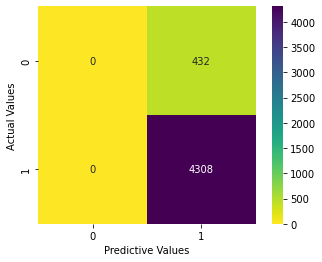

In [41]:
y_pred_test = model.predict(pool_test)

acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

cm = confusion_matrix(y_test, y_pred_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predictive Values')
ax.set_ylabel('Actual Values');

## 04. Feature Importances

통계적 데이터 분석
- 실패 확률을 낮추는 것.
- 적은 데이터에서 설명 가능한 변수를 찾고, 분석의 실패 가능성을 낮추는 것.

머신러닝 데이터 분석
- 변수들이 중요한 것이 아님.
- 변수들이 여러개 들어가도 좋으니 예측의 성공 가능성을 높이는 것.
    - 딥러닝이 이에 적합 (예측, 분류의 성능을 높히는 것에만 초점을 둠)

머신러닝이 딥러닝보다 나은 점이 바로 Feature Importance.

- 어떤 feature가 해당 모델에 가장 많은 기여를 했는지.
- 분석 결과를 시각화하고 설득하는 과정에 필요.

#### 1) Feature Importances 그래프 그리기

In [47]:
model.feature_names_

['acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'fico_range_low',
 'home_ownership',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'loan_amnt',
 'max_bal_bc',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'open_acc_

In [48]:
model.feature_importances_

array([ 0.85042889,  3.00695338,  1.09337406,  2.18274306,  1.22986908,
        0.24820161,  1.02137374,  2.02022936,  1.66591392,  0.15417488,
        0.21835053,  0.96071572,  0.03330372,  2.71648281,  0.58637471,
        3.14896291,  1.53739214,  1.36614317,  1.42579734,  1.5257113 ,
        2.21310904,  0.70467153,  3.02665214,  2.09401177, 10.82221541,
        1.09198242,  1.50816889,  0.64652052,  0.7752004 ,  1.40667956,
        1.04981929,  1.19594275,  0.84156064,  0.92190686,  0.84271201,
        0.9014686 ,  4.09876963,  1.2786517 ,  0.65221985,  1.55563509,
        0.94963353,  1.11335639,  0.80323184,  1.02488215,  0.89525359,
        2.17352393,  0.        ,  0.25995021,  0.74336927,  1.30364658,
        0.68799297,  0.44305079,  0.27138407,  0.37653441,  0.58762628,
        1.82290308,  1.85395035,  0.09707339,  0.26154067,  1.66291551,
        1.68433985,  2.24479804,  0.19649813,  3.04363019,  0.60283432,
        1.5770782 ,  0.55241237,  1.20110298,  1.33156915,  1.04

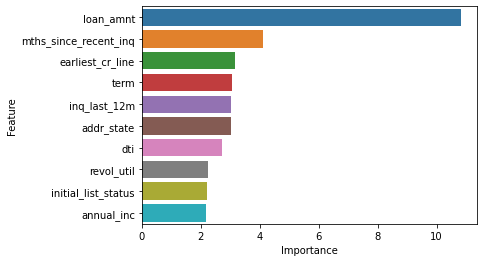

In [42]:
feat = model.feature_names_
imp = model.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);

얼마나 중요한지를 판단하기 위해 아래에서 관계도를 그려봐야함.

#### 2) 주요 3개 Feature와 건전/부실 대출 간 관계

- 대출액 히스토그램 상에서의 건전/부실 대출

- 대출액 중에서 Good group과 Bad group의 분포.
- 대출 금액이 적으면 Good group이 몰려 있음.

c:\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


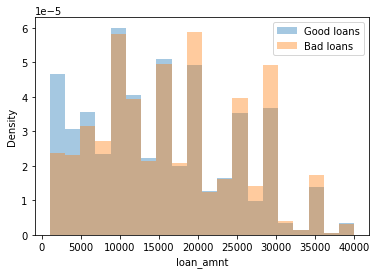

In [43]:
good = X_mod.loc[y_mod == 1, 'loan_amnt']
bad = X_mod.loc[y_mod == 0, 'loan_amnt']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

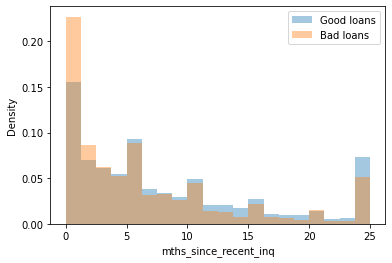

In [44]:
good = X_mod.loc[y_mod == 1, 'mths_since_recent_inq']
bad = X_mod.loc[y_mod == 0, 'mths_since_recent_inq']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();

- 1개월만에 다시 대출을 문의한 사람들이 Bad group에 포진.

c:\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


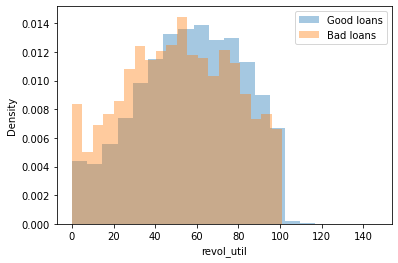

In [53]:
good = X_mod.loc[y_mod == 1, 'revol_util']
bad = X_mod.loc[y_mod == 0, 'revol_util']

bins = 20
sns.distplot(good, bins=bins, label='Good loans', kde=False, norm_hist=True)
ax = sns.distplot(bad, bins=bins, label='Bad loans', kde=False, norm_hist=True)
ax.set_ylabel('Density')
ax.legend();